# Taxi Drivers Go Where?
Part 1 - Data Cleaning\
Part 2 - EDA\
**Part 3 - Time Series Forecast**\
Part 4 - Deployment

# Import Library and Packages

In [1]:
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from pmdarima.arima import ADFTest 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import warnings
import time
import math

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(threshold=np.inf)

# Import Datasets

In [2]:
y_22 = pd.read_pickle('./datasets/cleaned_yellow_2022.pkl')

In [3]:
y_22.shape

(25348245, 4)

In [4]:
taxi_zone = pd.read_csv('./datasets/taxi+_zone_lookup.csv')
taxi_zone.shape

(265, 4)

## Dictionary for Taxi Trip Based on Pick Up Location Zones

In [5]:
%%time
# To extract the pickup and dropoff frequency based on zones

# Define an empty dictionary to store the new DataFrame
PickUp = {}
DropOff = {}

# Define empty dataframe to store the frequencies 
IDCount = pd.DataFrame()

# Each unique Pick Up Loaction ID is stored in the Dictionary for timeseries training
for ID in (sorted(y_22['PULocationID'].unique())):
    
    # define emoty datafrane for the new ID
    PickUp[ID] = pd.DataFrame()
    DropOff[ID] = pd.DataFrame()
    
    # extract rows where ID matches with the PULocationID
    PickUp[ID] = y_22[y_22['PULocationID'] == ID]
    DropOff[ID] = y_22[y_22['DOLocationID'] == ID]
    
    # Define the aggregated frequency in dataframe
    summ = pd.DataFrame({'LocationID': ID,
                         'PUFreq': PickUp[ID].shape[0],
                         'DOFreq': DropOff[ID].shape[0]},
                        index = [0])
    
    # Concat the dataframe
    IDCount = pd.concat([IDCount, summ])

# Reset index 
IDCount.reset_index(drop = True, inplace = True)

CPU times: user 4.54 s, sys: 901 ms, total: 5.44 s
Wall time: 5.55 s


In [6]:
# Return Zones with higherst PickUp Frequency
IDCount.sort_values(by =['PUFreq'], ascending = False).head()

,LocationID,PUFreq,DOFreq
233,237,1201458,1040297
128,132,1138832,292567
232,236,1069860,1097422
157,161,1034435,931335
182,186,854275,580963


In [7]:
# Return Zones with higherst DropOff Frequency
IDCount.sort_values(by =['DOFreq'], ascending = False).head()

,LocationID,PUFreq,DOFreq
232,236,1069860,1097422
233,237,1201458,1040297
157,161,1034435,931335
166,170,812199,772988
226,230,797221,753140


## Combine IDCount with Location Zone and Borough

In [8]:
count_df = IDCount.join(taxi_zone.set_index('LocationID'), on = 'LocationID')

## Demand of Taxis in the Zone

Identify the number of outstanding taxi in the zone within same period of time by `out_qty = (count of PULocationID) - (Count of DOLocationID)`. 

Due to the nature of the dataset, the location of picking up and dropping off are in a zone instead of exact coordinate. Taxis travel from zones to zones. To ensure the demand of taxi is at least more than the number of incoming taxi to the same zone, the `out_qty`  is deduced,

Positive integers represent the number of passenger is more than the number of available taxi from dropping off passengers.

Negative integers represent the number of available taxi is more than the number of passenger requesting for taxi.


In [9]:
'''
- Subdivide the PickUp and DropOff timing based on Zoning
- Identify the 'demand' by substrating the PickUp count with Dropoff count
- Remove all null values to zero
- Convert the datatypes to float16 to reduce the size of dictionary
'''
def zoning(period):
    # define empty dictionary
    zone = {}
    PU = {}
    DO = {}

    for ID in (sorted(y_22['PULocationID'].unique())):
        # To groupby the date time column into 1 hour segment and aggregate the value with number of pick up for that location in that period
        PU[ID] = pd.DataFrame(PickUp[ID].groupby(pd.Grouper(key = 'tpep_pickup_datetime', freq=period)).count())
        DO[ID] = pd.DataFrame(DropOff[ID].groupby(pd.Grouper(key = 'tpep_dropoff_datetime', freq=period)).count())

        # To define a DataFrame with number of count in the period
        zone[ID] = pd.DataFrame()
        zone[ID]['PUCount'] = PU[ID]['PULocationID']
        zone[ID]['DOCount'] = DO[ID]['DOLocationID']

        # To convert all Nan to 0
        zone[ID].replace(np.nan, 0, inplace = True)

        # Feature engineer the demand of taxi in the zone at the same time
        zone[ID]['demand'] = zone[ID]['PUCount'] - zone[ID]['DOCount']

        # Convert the datatype to reduce data size
        for col in zone[ID].columns:
            c_min = zone[ID][col].min()
            c_max = zone[ID][col].max()
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                zone[ID][col] = zone[ID][col].astype(np.float32)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                zone[ID][col] = zone[ID][ID][col].astype(np.float32)
            else:
                zone[ID][col] = zone[ID][col].astype(np.float64)

        # Rename the index
        zone[ID].index.names = ['datetime']
        
    return zone

In [10]:
%%time
# Aggregate frequency based on 30 minutes intervals
zone = zoning('30Min')

CPU times: user 8.23 s, sys: 412 ms, total: 8.64 s
Wall time: 8.77 s


Due to large number of zones in the vicinity, Zone 138 is used here for model training purposes and evaluation purpose.

In [11]:
zone[138].head(10)

,PUCount,DOCount,demand
datetime,,,
2022-01-01 00:00:00,16.00,1.00,15.00
2022-01-01 00:30:00,30.00,0.00,30.00
2022-01-01 01:00:00,10.00,3.00,7.00
2022-01-01 01:30:00,2.00,3.00,-1.00
2022-01-01 02:00:00,0.00,2.00,-2.00
2022-01-01 02:30:00,0.00,1.00,-1.00
2022-01-01 03:00:00,0.00,2.00,-2.00
2022-01-01 03:30:00,0.00,4.00,-4.00
2022-01-01 04:00:00,0.00,3.00,-3.00


**Inference:**

We could now see the datasets are now aggregated into time intervals.

# Seasonality

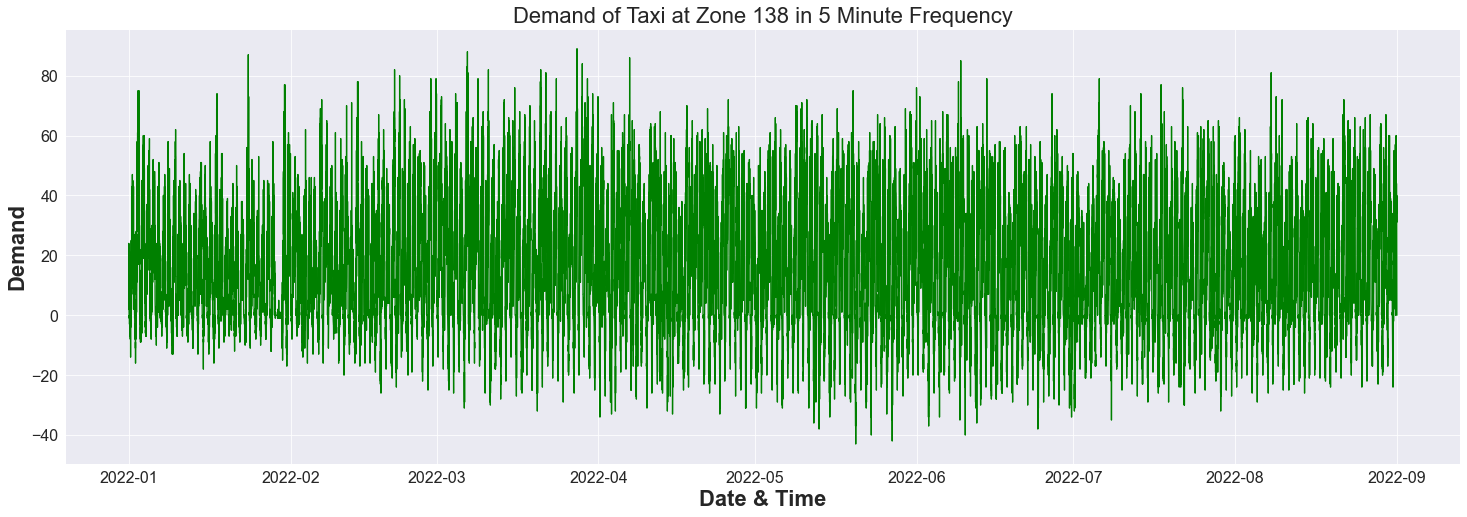

In [140]:
# Set figure size.
plt.figure(figsize=(25,8))

# Create line plot.
plt.plot(zone[138]['demand'], c ='green')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date & Time', fontsize=22)
plt.ylabel('Demand', fontsize=22)
plt.title('Demand of Taxi at Zone 138 in 5 Minute Frequency', fontsize=22);
plt.savefig('./image/demand_138.jpg')

**Inference:**

Seems like we could see that at Zone 138, the demand for taxi is relatively higher throughout the year as we could see the values are always positive and could hit to almost 40 while the smallest value is -20 only. This shows that the area has higher demand of taxi and also more passengers call for taxi at this zone. Also with the datasets being too many values, no trend could be seen. 

In [13]:
zone_138_08 = zone[138][(zone[138].index >= "2022-08-01") & (zone[138].index < "2022-08-31")]

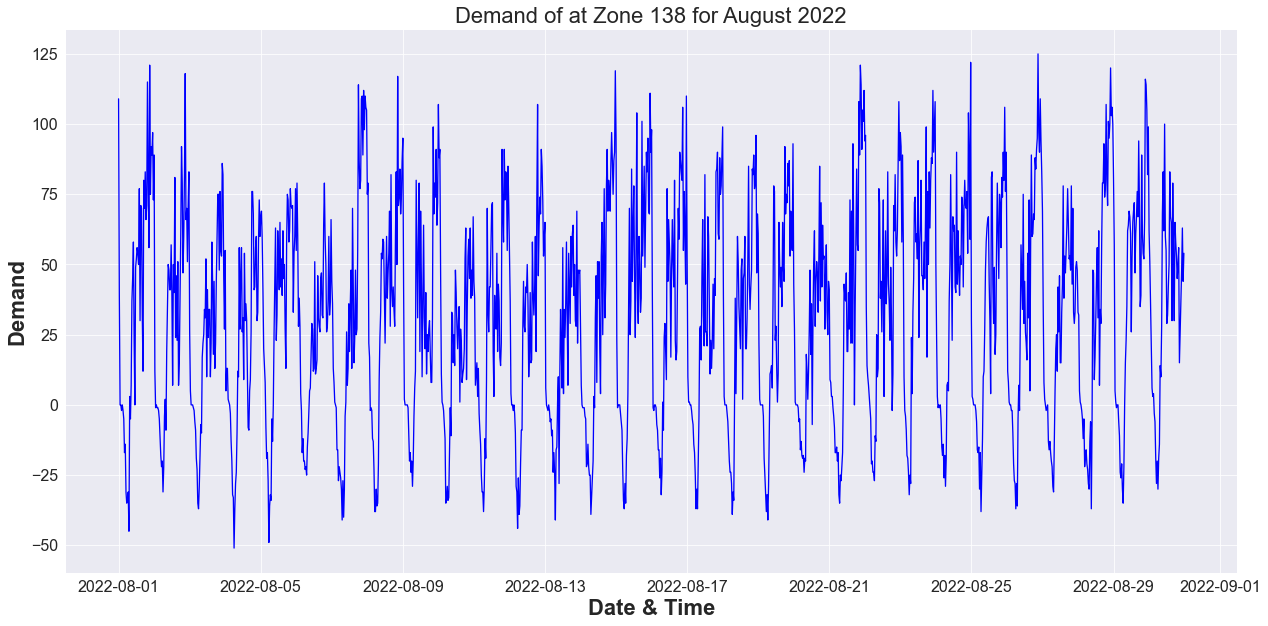

In [141]:
# Set figure size.
plt.figure(figsize=(21,10))

# Create line plot.
plt.plot(zone_138_08['demand'], c ='blue')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date & Time', fontsize=22)
plt.ylabel('Demand', fontsize=22)
plt.title('Demand of at Zone 138 for August 2022', fontsize=22);
plt.savefig('./image/demand_138_aug.jpg')

**Inference:**

We could see a gentle weekly trend in the plot above. The demand of oscilate from high to low demand and back to high again on daily basis but the peak of the high demands follows the weekly patterns

# Metric

There are many metrices which are suitable for timeseries prediction which are:
- Mean absolute percentage error (MAPE)
- Mean absolute error (MAE)
- Mean squared error (MSE)
- Root mean squared error (RMSE)
- Mean absolute scaled error (MASE)

However, for this project, we have negative integers and zeros. Hence, metrices that utilized division of original datasets will not be suitable as the value will be very big or close to infinitly. 

Thus, we decided and will be using `Root Mean Square Error (RMSE)` and `Mean Absolute Error (MAE)` as the metric to evaluate the performance of the model.

`RMSE` measures the average magnitude of the error. It is also square root of the average of squared difference between the actual and prediction values.

`MAE` takes the average of absolute errors for a group of predictions and observations as a measurement of the magnitude of errors for the entire group. The value starts from 0 and is indifferent to the direction of errors. This could be good for our values with negative intergers.

For both metrices, the lower the value, the better the model performance. However, for `RMSE`, it increases with the variance of the frequency distribution of error magnitudes. Hence, `RMSE` would be the main metric to evaluate the model performance and followed by `MAE` if the first metric is not giving good indication.

Lastly, `MAE` will be used for interpretation.



# Modeling

## Define Functions

### data_conversion(ID)
Conver the datatype to Time Series

In [15]:
# Data Conversion
'''
- To convert the datatype to Time Series for Usage in Darts
- To convert the values to non-zero or positive integer for usage in Darts
- To define arbitrary feature to keep the original data
'''
def data_conversion(ID):
    
    # Identify the minimum values in the feature
    min_value = int(abs(zone[ID]['demand'].min()))
    
    # Covert whole dataset to non-negative / non-zero values for modeling
    zone[ID]['s_demand'] = zone[ID]['demand'] + min_value + 1
    
    # Define empty dictionary to store data
    data = {}
    data['demand'] = (TimeSeries.from_series(zone[ID]['demand']).astype(np.float64))
    data['s_demand'] = (TimeSeries.from_series(zone[ID]['s_demand']).astype(np.float64))
    
    return data, min_value

### train_test(data)
Train test and split for model training

In [16]:
# Train Test Split
'''
- Carry out 75-25 split for Train and Test
- Identify the number of value in the dataset
- Return the number of Test Dataset 
'''
def train_test(data):
    train = {}
    test = {}
    for feature, ts in data.items():
        N = int(np.round((len(data[feature])) * 0.85,0))
        n = int(np.round((len(data[feature])) * 0.15,0))
        train[feature] = ts[:N]
        test[feature] = ts[N:]
        
    return  train, test, n

### plot_charts(train, test, preds)
Plot out charts for visualization

In [17]:
# Plot the charts of Actual vs Prediction
'''
- Overlay 2 lines on the same charts
- Only indicate the 1 month of actural before prediction portion due to large dataset
'''
def plot_charts(train, test, preds):
    plt.figure(figsize = (25,8))
    train_plot = {}
    
    # To plot train dataset 30 days prior to ease visualization
    for feature, ts in train.items():
        train_plot[feature] = ts[-8640:] 
        
    train_plot['demand'].plot(label = "actual")
    test['demand'].plot(label = "test", alpha = 0.5)
    preds['demand'].plot(label = "preds", alpha = 0.5) 
    

### model_eval(period, ID, feature, s_feature, model, description, summary)
to train, evaluate the model

In [18]:
# Model Evluation
'''
- Fit the Model with Trained Arbitrary Feature
- Predict with Arbitrary Feature
- Remove the additional values added to revert the value back to zero/ negative integer
- Return Mean Absolute Error & Root Mean Square Error
'''
def model_eval(period, ID, feature, s_feature, model, description, summary):
    
    start_time = time.time()
    
    # Covert the data to Timeseries & non-zero/non-negative
    data, min_value = data_conversion(ID)
    
    # Split for train & test
    train, test, n = train_test(data)
    
    # Scale the dataset and return the scaled dataset and scaler
    # ss_train, scaler = scale(train)
    
    # Fitting the model with train dataset
    # model.fit(ss_train[feature])
    model.fit(train[s_feature])
    
    # to do prediction
    # ss_preds = model.predict(n)
    sudo_preds = model.predict(n)
    
    # Revert predicted value to zero/negative value
    # Convert the TimeSeries datatype to DataFrame
    sudo_preds_df = sudo_preds.pd_dataframe()
    
    # Minus the additional values added
    sudo_preds_df[feature] = sudo_preds_df[s_feature] - min_value - 1
    
    # Convert the DataFrame to TimeSeries Datatype
    preds = TimeSeries.from_dataframe(sudo_preds_df).astype(np.float32)
        
    # MAE
    model_mae = mae([test[feature]], [preds[feature]])
    model_mape = mape([test[s_feature]], [preds[s_feature]])

    print(f'Model: {description} at Zone {ID}, MAE: {model_mae:.3f}, MAPE: {model_mape:.3f}')
    time_exe = (time.time() - start_time)
    
    # To store the result in dataframe
    result = pd.DataFrame({"zone": ID,
                           "time_frame": period,
                           "model": description,
                           "MAPE": model_mape,
                           "MAE": model_mae,
                           "execution_time (s)": time_exe},
                          index = [0])    
    
    summary = pd.concat([summary, result])
            
    return model_mae, model_mape, summary

### Define Empty DataFrame

In [19]:
# Define empty dataframe to store the results from the training and testing
summary_bronx = pd.DataFrame() # Zone 168
summary_brooklyn = pd.DataFrame() # Zone 65
summary_ewr = pd.DataFrame() # Zone 1
summary_manhattan = pd.DataFrame() # Zone 237
summary_queens = pd.DataFrame() # Zone 138
summary_staten_island = pd.DataFrame() # Zone 23

## ARIMA Model (Baseline Model) at Zone 138 (Queens)
Autoregressive integrated moving average.
The order and moving average are done based on the Autocorrelation and Partial Autocorrelation charts. From the charts above, we will input MA or q = 7 and seasonality of daily (24)

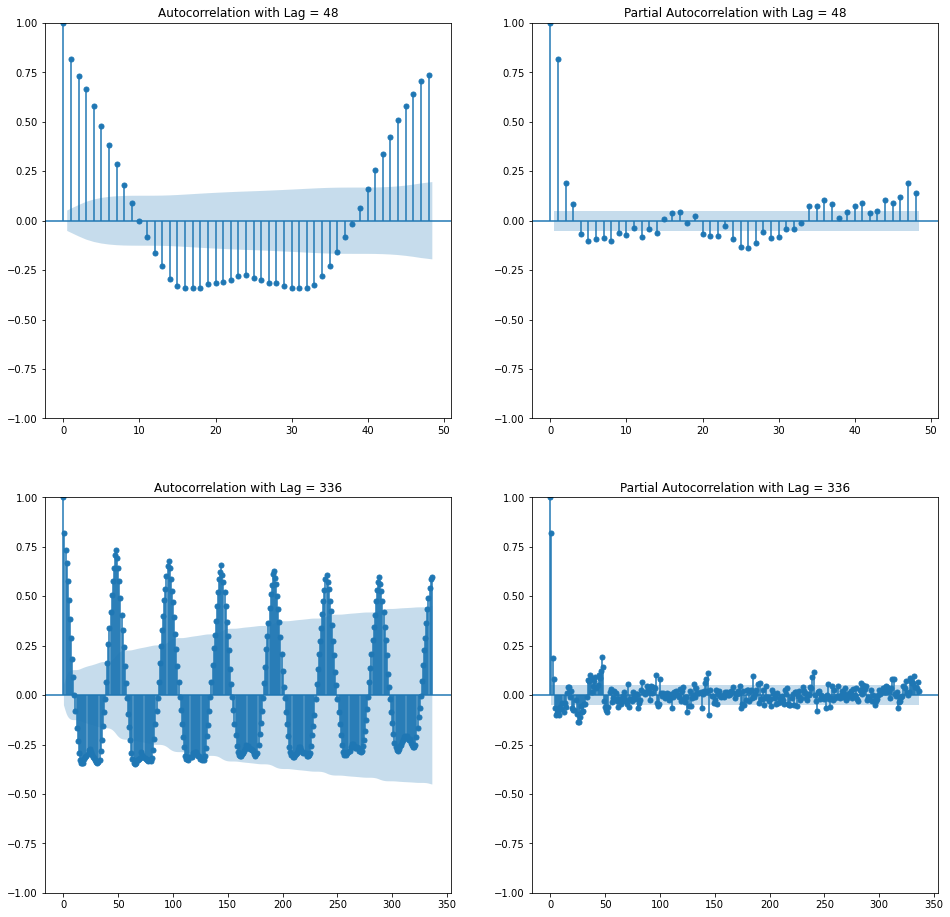

In [20]:
# 24 hours and 1 week  Autocorr and Partial Autocorr charts
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
fig = plot_acf(zone_138_08["demand"], lags=48 , ax=ax1, title ='Autocorrelation with Lag = 48')
ax2 = fig.add_subplot(222)
fig = plot_pacf(zone_138_08["demand"], lags=48, ax=ax2, title ='Partial Autocorrelation with Lag = 48');
ax3 = fig.add_subplot(223)
fig = plot_acf(zone_138_08["demand"], lags=336, ax=ax3, title ='Autocorrelation with Lag = 336');
ax4 = fig.add_subplot(224)
fig = plot_pacf(zone_138_08["demand"], lags=336, ax=ax4, title ='Partial Autocorrelation with Lag = 336');

plt.show()

**Inference:**

Based on the 1 day and 1 week Autocorrelation charts, we could see exponentially decaying charts wherease the Autocorrelation charts. In the Partial Autocorrelation Charts, 10 points are out from the 95% significance zone. Those points within the shaded space are likely to be noise and do not have any valuable correlation. 

Here, we infer that this could be a AR(10) model and Seasonal on daily or weekly basis which is lag 48 and 336.


In [21]:
# Import Darts Library
from darts import TimeSeries, concatenate
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, Theta, ARIMA, Croston, RandomForest
from darts.metrics import mae, mape, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

In [22]:
arima = ARIMA(p = 10, d = 0, q = 0, trend = 'c', random_state = 123) 

In [23]:
period = '30Min'
zone = zoning(period)
arima_mae, arima_rmse, summary_queens = model_eval(period, ID, 'demand', 's_demand', arima, 'ARIMA', summary_queens) 

Model: ARIMA at Zone 263, MAE: 15.902, MAPE: 26.597


Inference:

ARIMA model or SARIMA model requires large computational capacity and longer time to train the model. Hence, ARIMA or SARIMA model will not be used.

## NaiveDrift Model (Baseline Model)
 This model fits a line between the first and last point of the training series and extends the line when continuing the fitting.

In [25]:
naive_drift = NaiveDrift()

## Theta Method
The trained time series is de-seasonalized according to seasonality_period

In [24]:
def m_theta(season):
    theta = Theta(theta=1.8, seasonality_period=season)
    
    return theta

## Naive Seasonal Model 
The model predicst the value of `K` time steps ago. `K` is the seasonality part of the data where the model predicts the last `K` steps of the training set. When `K` = 1, the model predicts the last value of the training set. When `K`> 1, it repeats the last `K` values of the training set

In this model, we are doing `K` for Weekly Seasonality

In [26]:
def m_n_seasonal(season):
    
    # Initiate the Theta model 
    # seasonality_period is set based on the aggregated period
    # As the datasets is highly seasonal on weekly basis, 
    # seasonality_period is set to be on 1 week time frame
    naive_seasonal = NaiveSeasonal(K = season)
    
    return naive_seasonal

## Croston Model 
The model is specifically designed to forecast time series with intermittent demand.

In [27]:
croston = Croston(version = 'classic')

## Exponential Smoothing
Wrap around statsmodels Holt-Winters' Exponential Smoothing method in which the method uses exponential smoothing to encode the values from the past for prediction on seasonality values for the present and future.

In [28]:
def m_exp_smooth(season):
    exp_smooth = ExponentialSmoothing(trend = ModelMode.NONE,
                                      seasonal = SeasonalityMode.MULTIPLICATIVE,
                                      seasonal_periods = season)
    
    return exp_smooth

## Random Forest
Using random forest regression, it uses some of the target series' lags to oobtain forecast

In [29]:
def m_r_forest(season):
    random_forest = RandomForest(lags = season, max_depth = 15)
    
    return random_forest

## Model Training & Testing

In [30]:
# Define a function to train and test model
def model_train(ID, summary):
    for period in periods:
        if period == '5Min':
            season = 24*12*7
        elif period == '15Min':
            season = 24*4*7
        else:
            season = 24*2*7

        # Aggregate the time based on period
        zone = zoning(period)

        # Theta Model
        theta = m_theta(season)
        theta_mae, theta_rmse, summary = model_eval(period, ID, 'demand', 's_demand', theta, 'Theta', summary) 

        # Naive Drift Model
        naive_drift_mae, naive_drift_rmse, summary = model_eval(period, ID, 'demand', 's_demand', naive_drift, 'NaiveDrift', summary)

        # Naive Seasonal Model
        naive_seasonal = m_n_seasonal(season)
        naive_seasonal_mae, naive_seasonal_rmse, summary = model_eval(period, ID, 'demand', 's_demand', naive_seasonal, 'NaiveSeasonal', summary)

        # Croston Model
        croston_mae, croston_rmse, summary = model_eval(period, ID, 'demand', 's_demand', croston, 'Croston', summary)

        # Exponential Smoothing Model
        exp_smooth = m_exp_smooth(season)
        exp_smooth_mae, exp_smooth_rmse, summary = model_eval(period, ID, 'demand', 's_demand', exp_smooth, 'ExponentialSmoothing', summary)

        # Random Forest Model
        random_forest = m_r_forest(season)
        random_forest_mae, random_forest_smooth_rmse, summary = model_eval(period, ID, 'demand', 's_demand', random_forest, 'RandomForest', summary)
        
    return summary

## Dataset Aggregation Period
Taxis are always on demand and ideally able to predict the demand on the spot. To check on the accuracy and run time of the datasets, several period is set to identify the best model for deployment.

In [31]:
# Define the aggregated period for the dataset
periods = ['5Min', '15Min', '30Min']

## Train on all 5 selected zones from each Borough

In [32]:
%%time
summary_queens = model_train(138, summary_queens)
summary_bronx = model_train(168, summary_bronx)
ummary_brooklyn = model_train(63, summary_brooklyn)
summary_ewr = model_train(1, summary_ewr)
summary_manhattan = model_train(237, summary_manhattan)
summary_staten_island = model_train(23, summary_staten_island)

Model: Theta at Zone 138, MAE: 14.131, MAPE: 12.775
Model: NaiveDrift at Zone 138, MAE: 45.693, MAPE: 60.490
Model: NaiveSeasonal at Zone 138, MAE: 18.334, MAPE: 16.699
Model: Croston at Zone 138, MAE: 32.375, MAPE: 38.089
Model: ExponentialSmoothing at Zone 138, MAE: 19.890, MAPE: 19.357
Model: RandomForest at Zone 138, MAE: 14.463, MAPE: 13.278
Model: Theta at Zone 138, MAE: 14.199, MAPE: 13.442
Model: NaiveDrift at Zone 138, MAE: 45.693, MAPE: 60.490
Model: NaiveSeasonal at Zone 138, MAE: 17.742, MAPE: 16.126
Model: Croston at Zone 138, MAE: 32.375, MAPE: 38.089
Model: ExponentialSmoothing at Zone 138, MAE: 14.204, MAPE: 13.269
Model: RandomForest at Zone 138, MAE: 14.962, MAPE: 13.474
Model: Theta at Zone 138, MAE: 14.128, MAPE: 13.342
Model: NaiveDrift at Zone 138, MAE: 45.693, MAPE: 60.490
Model: NaiveSeasonal at Zone 138, MAE: 18.391, MAPE: 16.842
Model: Croston at Zone 138, MAE: 32.375, MAPE: 38.089
Model: ExponentialSmoothing at Zone 138, MAE: 14.515, MAPE: 13.405
Model: Rando

## Summary

In [145]:
summary = pd.concat([summary_queens, 
                     summary_bronx, 
                     ummary_brooklyn, 
                     summary_ewr, 
                     summary_manhattan, 
                     summary_staten_island]) 
summary.reset_index(inplace = True, drop = True)

summary.head()

,zone,time_frame,model,MAPE,MAE,execution_time (s)
0,263,30Min,ARIMA,26.60,15.90,1.79
1,138,5Min,Theta,12.78,14.13,0.07
2,138,5Min,NaiveDrift,60.49,45.69,0.02
3,138,5Min,NaiveSeasonal,16.70,18.33,0.01
4,138,5Min,Croston,38.09,32.37,2.04


In [149]:
summary = summary[summary['model'] != 'ARIMA']

In [147]:
summary[summary['time_frame'] == '5Min'].sort_values('zone')

,zone,time_frame,model,MAPE,MAE,execution_time (s)
60,1,5Min,RandomForest,6.73,2.00,304.23
59,1,5Min,ExponentialSmoothing,25.48,8.38,"1,167.19"
58,1,5Min,Croston,14.22,4.24,0.01
57,1,5Min,NaiveSeasonal,9.77,2.96,0.01
56,1,5Min,NaiveDrift,14.78,4.32,0.01
55,1,5Min,Theta,7.22,2.21,0.08
96,23,5Min,RandomForest,2.86,0.13,53.22
94,23,5Min,Croston,2.61,0.12,0.01
93,23,5Min,NaiveSeasonal,3.69,0.17,0.01
92,23,5Min,NaiveDrift,3.57,0.17,0.01


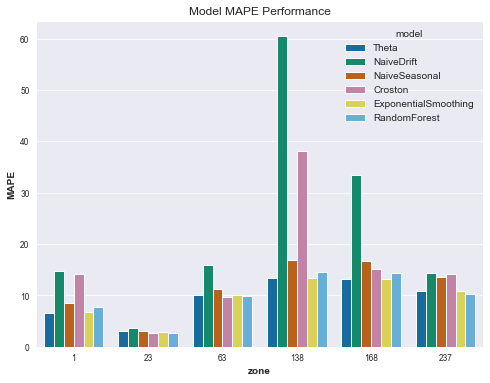

In [153]:
plt.figure(figsize=(8,6))
plt.title('Model MAPE Performance')
sns.barplot(data=summary[summary['time_frame'] == '30Min'], 
            x='zone', y='MAPE', hue='model').set_ylabel('MAPE');
plt.savefig('./image/model_mape.jpg')

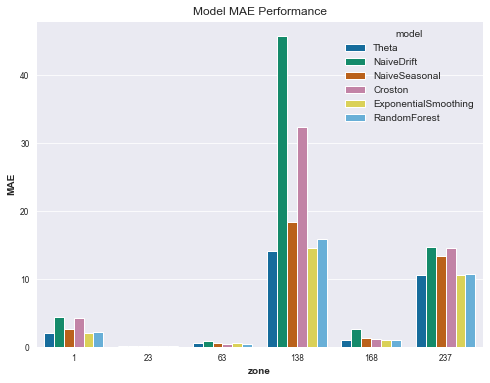

In [161]:
plt.figure(figsize=(8,6))
plt.title('Model MAE Performance')
sns.barplot(data=summary[summary['time_frame'] == '30Min'], 
            x='zone', y='MAE', hue='model').set_ylabel('MAE');
plt.savefig('./image/model_mae.jpg')

Inference:

Generally, the models that are performing which has lower MAPE are:
- Theta
- Exponential Smoothing
- Random Forest

These models have better performance than the rest

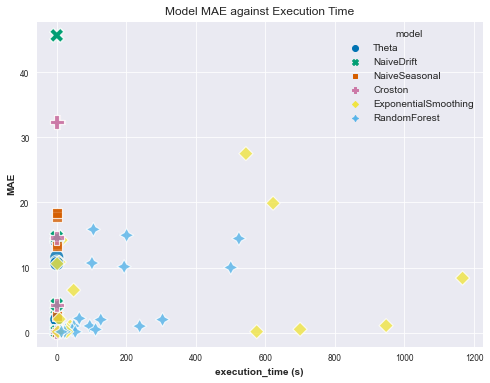

In [158]:
# Plot scatter plot of the performance based on time intervals
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data = summary, x ='execution_time (s)', 
                y = 'MAE', hue = 'model', ax = ax, style="model", s = 200, alpha = 0.8
               ).set(title = 'Model MAE against Execution Time')
plt.savefig('./image/model_mae_time.jpg')

Inference: 

We could see a very significant longer executive time is required for both Exponential Smoothing and Random Forest model. 
With the limited computational power, it is decided to proceed with Theta Model for further training and deployment.

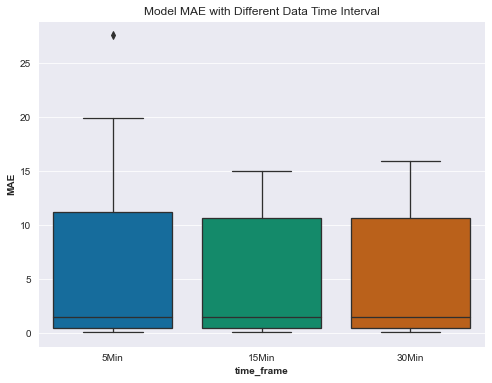

<Figure size 432x288 with 0 Axes>

In [160]:
# Plot scatter plot of the performance based on time intervalc
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize = (8,6))
sns.boxplot(data = summary[summary['model'].isin(['Theta', 'ExponentialSmoothing', 'RandomForest'])], y ='MAE', x = 'time_frame', order = ['5Min', '15Min', '30Min'], ax = ax
               ).set(title = 'Model MAE with Different Data Time Interval')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()
plt.savefig('./image/model_mae_time_interval.jpg')

Inference:

From the Box Plot above, the MAE is relatively similar across 3 periods. The average MAE is also closed with the rest. Since it has smaller gap of error, 15Mins timeframe is selected for deployment as it has relatively smaller MAE than the other time period.

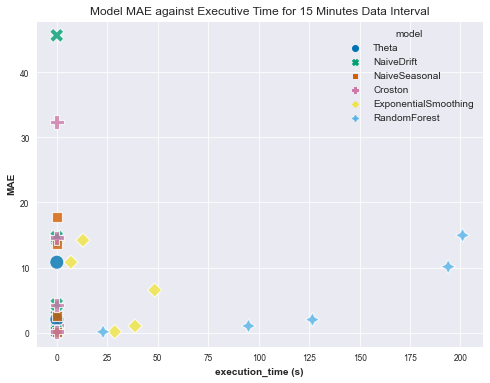

In [125]:
# Define the summary of 5 Mins interval dataset
summary_5 = summary[summary['time_frame'] == '15Min']

# Plot scatter plot of the performance
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data = summary_5, x ='execution_time (s)', 
                y = 'MAE', hue = 'model', ax = ax, style="model", s = 200, alpha = 0.8
               ).set(title = 'Model MAE against Executive Time for 15 Minutes Data Interval')
# plt.ylim(0,10)
plt.show()

Inference:

Based on the summary above, comparing the MAPE, all models definitely outperformed the Baseline Model NaiveDrift. 

There are 3 models have relatively near MAPE and MAE which are Theta Mode, Exponential Smoothing Model and Random Forest. These models in general have lower MAPE & MAE. From here, we could infer that the prediction from these models are deviating from the MAE values from the prediction. 

To choose the best model for deployment, considering the objectives for this project, we need a model that has the fastest executive time. With this in mind, Theta model outshines the rest. It used less than a quarter of second to do the training and prediction. With each zones having neighbors and could up to 5 neighbors, we require model that could be executed as fast as possible to reduce the wait time. Hence, Theta model is chosen for deployment and further training.

# Model Training for Deployment
With 263 zones with different datasets, each zones will have its own model to carry out the prediction. 

All models will be trained under the period of 15-min and the predictions will be stored as a DataFrame and export as CSV file.

Zones with insufficient datasets will then be list down as `no_pred_zone`. Theta_summary of all the zones will also be stored for interpretation.

In [126]:
# MASS MODEL Training and Prediciton
'''
- Fit the Model with Trained Arbitrary Feature
- Predict with Arbitrary Feature
- Remove the additional values added to revert the value back to zero/ negative integer
- Return Mean Absolute Error & Root Mean Square Error
'''
def mass_pred(period, ID, feature, s_feature, model, description, summary, prediction):
    
    # To obtain the time of prediction
    # Obtain current Timing in datetime format
    current_time = pd.to_datetime('2023-01-01 00:00:00')

    # To begining timing the execution
    start_time = time.time()
    
    # Covert the data to Timeseries & non-zero/non-negative
    data, min_value = data_conversion(ID)
    
    # Split for train & test
    train, test, n = train_test(data)
    
    # To obtain the last timing of trained time
    train_time = train['s_demand'].end_time()
    
    # Scale the dataset and return the scaled dataset and scaler
    # ss_train, scaler = scale(train)
    
    # Fitting the model with train dataset
    # model.fit(ss_train[feature])
    # with mlflow.start_run():
    model.fit(train[s_feature])

    # to do prediction
    # ss_preds = model.predict(n)
    sudo_preds = model.predict(n)

    # Revert predicted value to zero/negative value
    # Convert the TimeSeries datatype to DataFrame
    sudo_preds_df = sudo_preds.pd_dataframe()

    # Minus the additional values added
    sudo_preds_df[feature] = sudo_preds_df[s_feature] - min_value - 1

    # Convert the DataFrame to TimeSeries Datatype
    preds = TimeSeries.from_dataframe(sudo_preds_df).astype(np.float32)

    
    # MAE
    model_mae = mae([test[feature]], [preds[feature]])
    model_mape = mape([test[s_feature]], [preds[s_feature]])

    print(f'Model: {description} at Zone {ID}, MAE: {model_mae:.3f}, MAPE: {model_mape:.3f}')
    time_exe = (time.time() - start_time)
        
    # Identify the number of interval for prediction
    N =math.ceil((current_time - train_time)/'5Min')
    print(N)
    
    # To store the result in dataframe
    result = pd.DataFrame({"zone": ID,
                           "time_frame": period,
                           "model": description,
                           "MAPE": model_mape,
                           "MAE": model_mae,
                           "execution_time (s)": time_exe},
                          index = [0])    
    
    summary = pd.concat([summary, result])
    
    # Actual Prediction
    sudo_preds_act = model.predict(N)

    # Revert predicted value to zero/negative value
    # Convert the TimeSeries datatype to DataFrame
    sudo_preds_act_df = sudo_preds_act.pd_dataframe()

    # Minus the additional values added
    sudo_preds_act_df[feature] = sudo_preds_act_df[s_feature] - min_value - 1

    # change the name of the features
    sudo_preds_act_df.rename(columns = {feature : ID}, inplace = True)
    sudo_preds_act_df.drop(columns = [s_feature], inplace = True)
    prediction = pd.concat([prediction, sudo_preds_act_df],axis=1, join="outer")
            
    return model, summary, prediction

In [127]:
# Define the aggregated period for the dataset
final_period = '15Min'

In [128]:
zone = zoning(final_period)

In [129]:
# zone = zoning(period)
season = 24*4*7

In [130]:
# Define empty dataframe to store the results from the training and testing
theta_summary = pd.DataFrame()

In [131]:
# Define empty dataframe for storing the prediction output
prediction = pd.DataFrame()

In [132]:
# Define empty list to store zone ID without prediction
no_pred_zone = []

In [133]:
%%time
for area in range(1, 264):
    
    try: # Theta Model
    # Initiate the model
        theta = m_theta(season)

        # return the model with 
        globals()[f'zone_{area}'], theta_summary, prediction = mass_pred(final_period, area, 'demand', 's_demand', theta, 'Theta', theta_summary, prediction)


        locals()['zone_' + str(area)].save("./models/zone_"+str(area)+".pkl")
    # pickle.dump(('zone_' + str(area)), open('zone_'+str(area)+'.pkl', 'wb'))
    except:
        print(f'Zone_{area} does not have Model')
        no_pred_zone.append(area)
        pass

Model: Theta at Zone 1, MAE: 1.497, MAPE: 6.308
45660
Model: Theta at Zone 2, MAE: 0.004, MAPE: 0.217
45777
Model: Theta at Zone 3, MAE: 0.158, MAPE: 4.865
45576
Model: Theta at Zone 4, MAE: 1.671, MAPE: 8.429
45636
Model: Theta at Zone 5, MAE: 0.040, MAPE: 1.395
45723
Model: Theta at Zone 6, MAE: 0.035, MAPE: 1.479
47484
Model: Theta at Zone 7, MAE: 1.560, MAPE: 6.557
45639
Model: Theta at Zone 8, MAE: 0.061, MAPE: 2.404
46374
Model: Theta at Zone 9, MAE: 0.233, MAPE: 4.319
46095
Model: Theta at Zone 10, MAE: 0.966, MAPE: 10.842
45639
Model: Theta at Zone 11, MAE: 0.172, MAPE: 5.260
45888
Model: Theta at Zone 12, MAE: 1.421, MAPE: 12.003
45657
Model: Theta at Zone 13, MAE: 4.397, MAPE: 13.884
45636
Model: Theta at Zone 14, MAE: 0.688, MAPE: 9.097
45639
Model: Theta at Zone 15, MAE: 0.223, MAPE: 5.256
45612
Model: Theta at Zone 16, MAE: 0.329, MAPE: 8.022
45585
Model: Theta at Zone 17, MAE: 0.865, MAPE: 6.720
45639
Model: Theta at Zone 18, MAE: 0.275, MAPE: 6.368
45747
Model: Theta at 

In [134]:
# Reset the index for summary table
theta_summary.reset_index(inplace = True, drop = True)

# Export the model performance to pkl file
theta_summary.to_pickle('./datasets/model_score.pkl')
theta_summary.head(10)

,zone,time_frame,model,MAPE,MAE,execution_time (s)
0,1,15Min,Theta,6.31,1.50,0.11
1,2,15Min,Theta,0.22,0.00,0.07
2,3,15Min,Theta,4.87,0.16,0.06
3,4,15Min,Theta,8.43,1.67,0.07
4,5,15Min,Theta,1.40,0.04,0.06
5,6,15Min,Theta,1.48,0.04,0.06
6,7,15Min,Theta,6.56,1.56,0.06
7,8,15Min,Theta,2.40,0.06,0.06
8,9,15Min,Theta,4.32,0.23,0.06
9,10,15Min,Theta,10.84,0.97,0.06


In [135]:
# Export the model predictions to pickle file for deployment
prediction.to_pickle('./datasets/y_22_preds.pkl')

In [136]:
# Export the list of zones without model to txt file
f = open("./datasets/no_pred_zone.txt", "w")
f.write(str(no_pred_zone))
f.close()